<a href="https://colab.research.google.com/github/Waleed-Dexter/Netflix-EDA/blob/main/netflix_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# <- this is your folder from the screenshot
BASE = "/content/drive/MyDrive/Colab Notebooks/Netflix EDA"

# make subfolders for outputs
import os
os.makedirs(f"{BASE}/images", exist_ok=True)
os.makedirs(f"{BASE}/outputs", exist_ok=True)

print("Project ready at:", BASE, "\nContents:", os.listdir(BASE))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project ready at: /content/drive/MyDrive/Colab Notebooks/Netflix EDA 
Contents: ['netflix_titles_2021.csv', 'netflix img.png', 'images', 'outputs', 'README.md', 'netflix_eda.ipynb']


In [2]:
!pip -q install pandas numpy matplotlib seaborn plotly scikit-learn

In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MultiLabelBinarizer

pd.set_option("display.max_columns", 200)
sns.set(context="talk", style="whitegrid")

CSV_PATH = f"{BASE}/netflix_titles_2021.csv"
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.info()
df.isna().sum().sort_values(ascending=False).head(10)
df.duplicated().sum()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [5]:
# Convert dates & numeric fields
df["date_added"]   = pd.to_datetime(df.get("date_added"), errors="coerce")
df["release_year"] = pd.to_numeric(df.get("release_year"), errors="coerce").astype("Int64")

# Fill common text fields
for col, fill in [("country","Unknown"), ("director","Not Available"), ("cast","Not Available")]:
    if col in df.columns:
        df[col] = df[col].fillna(fill)

# Extract calendar parts
df["year_added"]  = df["date_added"].dt.year
df["month_added"] = df["date_added"].dt.month
df["day_added"]   = df["date_added"].dt.day

# Drop exact duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
df.head(3)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,day_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Not Available,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,25.0
1,s2,TV Show,Blood & Water,Not Available,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,9.0,24.0


In [6]:
# duration → minutes (movies) or seasons (tv)
if "duration" in df.columns and "type" in df.columns:
    dur = df["duration"].fillna("")
    is_movie = df["type"].eq("Movie")
    is_show  = df["type"].eq("TV Show")

    # pull numbers safely
    df["duration_minutes"] = np.where(
        is_movie,
        pd.to_numeric(dur.str.extract(r"(\d+)\s*min", expand=False), errors="coerce"),
        np.nan
    )
    df["seasons"] = np.where(
        is_show,
        pd.to_numeric(dur.str.extract(r"(\d+)\s*Season", expand=False), errors="coerce"),
        np.nan
    )

# genres (listed_in) → multi-hot encoding
if "listed_in" in df.columns:
    df["genres"] = df["listed_in"].fillna("").str.split(", ")
    mlb = MultiLabelBinarizer()
    genre_dummies = pd.DataFrame(
        mlb.fit_transform(df["genres"]),
        columns=[g.strip() for g in mlb.classes_],
        index=df.index
    )
    df = pd.concat([df, genre_dummies], axis=1)

df.sample(3)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,day_added,duration_minutes,seasons,genres,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,Documentaries,Docuseries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,International TV Shows,Kids' TV,Korean TV Shows,LGBTQ Movies,Movies,Music & Musicals,Reality TV,Romantic Movies,Romantic TV Shows,Sci-Fi & Fantasy,Science & Nature TV,Spanish-Language TV Shows,Sports Movies,Stand-Up Comedy,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
5973,s5974,Movie,#Roxy,Michael Kennedy,"Jake Short, Sarah Fisher, Booboo Stewart, Dann...",Canada,2019-04-10,2018,TV-14,105 min,"Comedies, Romantic Movies",A teenage hacker with a huge nose helps a cool...,2019.0,4.0,10.0,105.0,NaN,"[Comedies, Romantic Movies]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6583,s6584,Movie,Death at a Funeral,Neil LaBute,"Chris Rock, Martin Lawrence, Tracy Morgan, Dan...",United States,2020-08-01,2010,R,93 min,Comedies,"When a Los Angeles family's patriarch dies, hi...",2020.0,8.0,1.0,93.0,NaN,[Comedies],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7296,s7297,Movie,Lez Bomb,Jenna Laurenzo,"Jenna Laurenzo, Deirdre O'Connell, Brandon Mic...",United States,2019-02-07,2018,TV-14,90 min,"Comedies, LGBTQ Movies",A young woman's attempt to come out of the clo...,2019.0,2.0,7.0,90.0,NaN,"[Comedies, LGBTQ Movies]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


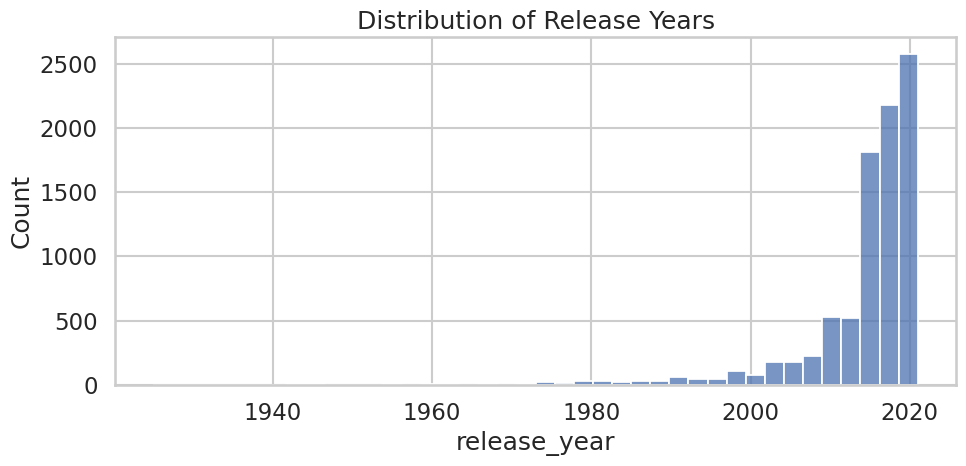

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(df["release_year"].dropna(), bins=40)
plt.title("Distribution of Release Years")
plt.tight_layout()
plt.savefig(f"{BASE}/images/release_year_hist.png", dpi=150)
plt.show()


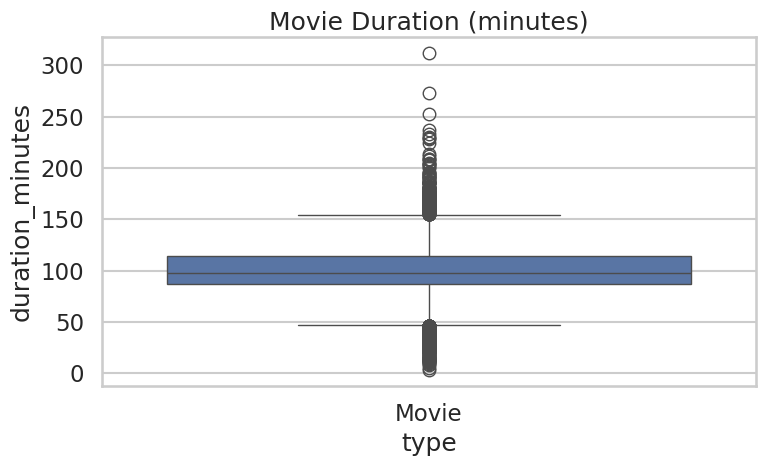

In [8]:
if "duration_minutes" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="type", y="duration_minutes", data=df[df["type"].eq("Movie")])
    plt.title("Movie Duration (minutes)")
    plt.tight_layout()
    plt.savefig(f"{BASE}/images/movie_duration_boxplot.png", dpi=150)
    plt.show()


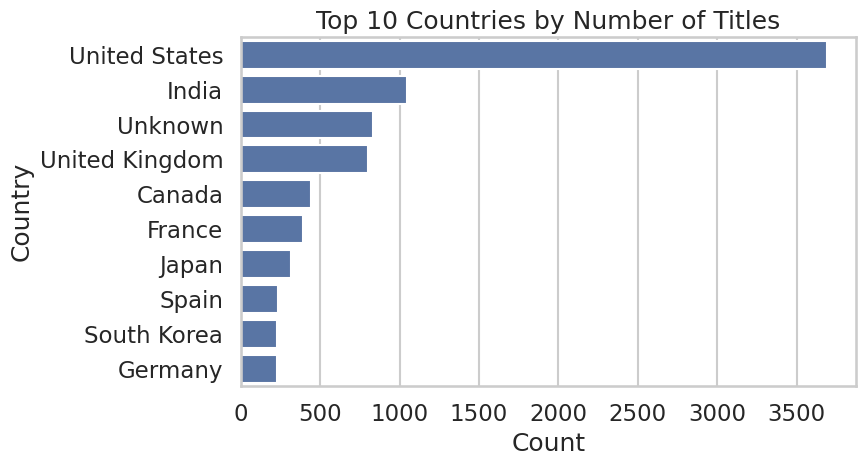

In [9]:
if "country" in df.columns:
    top_countries = df["country"].str.split(", ").explode().value_counts().head(10)
    plt.figure(figsize=(9,5))
    sns.barplot(x=top_countries.values, y=top_countries.index)
    plt.xlabel("Count"); plt.ylabel("Country")
    plt.title("Top 10 Countries by Number of Titles")
    plt.tight_layout()
    plt.savefig(f"{BASE}/images/top_countries.png", dpi=150)
    plt.show()


In [10]:
if {"release_year","type"}.issubset(df.columns):
    fig = px.histogram(df, x="release_year", color="type", nbins=40,
                       title="Releases by Year (Interactive)")
    fig.write_html(f"{BASE}/images/releases_by_year_interactive.html")
    fig.show()


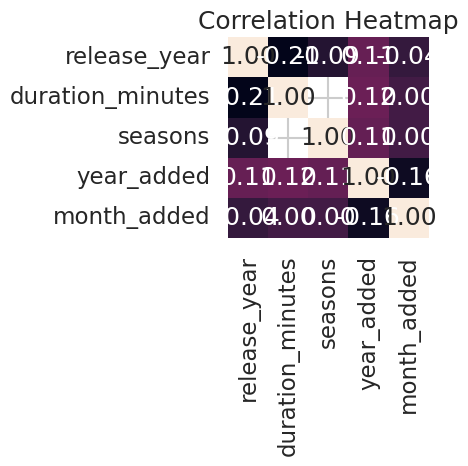

In [11]:
num_cols = [c for c in ["release_year","duration_minutes","seasons","year_added","month_added"] if c in df.columns]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{BASE}/images/correlation_heatmap.png", dpi=150)
plt.show()


In [12]:
out_csv = f"{BASE}/outputs/netflix_clean.csv"
df.to_csv(out_csv, index=False)

insights = {
    "rows": len(df),
    "movies": int(df["type"].eq("Movie").sum()) if "type" in df.columns else None,
    "tv_shows": int(df["type"].eq("TV Show").sum()) if "type" in df.columns else None,
    "year_span": (int(df["release_year"].min()), int(df["release_year"].max())) if "release_year" in df.columns else None,
    "avg_movie_mins": float(df.loc[df.get("type","")=="Movie","duration_minutes"].mean()) if "duration_minutes" in df.columns else None
}
insights, out_csv


({'rows': 8807,
  'movies': 6131,
  'tv_shows': 2676,
  'year_span': (1925, 2021),
  'avg_movie_mins': 99.57718668407311},
 '/content/drive/MyDrive/Colab Notebooks/Netflix EDA/outputs/netflix_clean.csv')

In [13]:
readme = f"""# Netflix EDA 🎬

This notebook explores the Netflix Movies & TV Shows dataset.

## What this repo includes
- Data cleaning & type fixes
- Engineered features: `duration_minutes`, `seasons`, `genres`
- Visualizations saved in `images/`
- Correlation analysis
- Cleaned CSV in `outputs/netflix_clean.csv`

## Quick stats
- Rows: {insights['rows']}
- Movies: {insights['movies']}, TV Shows: {insights['tv_shows']}
- Release year span: {insights['year_span']}
- Avg movie duration: {insights['avg_movie_mins']:.1f} minutes

## How to run
Open this notebook in Google Colab, mount Drive, set `BASE`, and run cells top-to-bottom.
"""
with open(f"{BASE}/README.md", "w", encoding="utf-8") as f:
    f.write(readme)

print("README created at:", f"{BASE}/README.md")


README created at: /content/drive/MyDrive/Colab Notebooks/Netflix EDA/README.md
